##Instructions

If you are marking this assignment and want to use the test data make sure marker_mode is set to True and provide the test data and test labels below.
Otherwise set marker mode to False.

In [ ]:
marker_mode = True
# Provide test data and true test labels here
test_data = None
test_labels = None

##Import packages

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from googleapiclient.http import MediaIoBaseDownload

import numpy as np
from scipy.stats import bernoulli
import h5py

import time
import matplotlib.pyplot as pl

np.random.seed(42)

##Download data

In [ ]:
# Google drive id of the data
train_data_id = '1CAqSwLA1yibqBr5psO6v-FpW9DQFB6ud'
train_labels_id = '1qMwn7TM8reBqdrWKiPCi8jtRLNPRKc7w'

# Download training data
downloaded = drive.CreateFile({'id':train_data_id}) 
downloaded.GetContentFile('train_128.h5')
with h5py.File('train_128.h5','r') as H:
    data = np.copy(H['data'])

# Download training labels
downloaded = drive.CreateFile({'id':train_labels_id}) 
downloaded.GetContentFile('train_label.h5')
with h5py.File('train_label.h5','r') as H:
    label = np.copy(H['label'])

##Preprocess data

###Normalize data

In [ ]:
def normalize_data(data):
    nom = (data-data.min(axis=0))*(2)
    denom = data.max(axis=0) - data.min(axis=0)
    denom[denom==0] = 1
    data = -1 + nom/denom
    return data

### Split into training and test set

In [ ]:
if marker_mode:
    data = normalize_data(data)
    X_train = data
    y_train = label
    if test_data is not None:
        test_data = normalize_data(test_data)
        X_test = test_data
        y_test = test_labels
    else:
        X_test = None
        y_test = None
else:
    data = normalize_data(data)
    #Stratified splitting of the data into train and test sets.
    y=np.array(label)
    train_index = np.zeros(len(y),dtype=bool)
    test_index = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_index = np.nonzero(y==value)[0]
        np.random.shuffle(value_index)
        n = int(0.7*len(value_index))
        train_index[value_index[:n]]=True
        test_index[value_index[n:]]=True

    X_train = data[train_index]
    y_train = label[train_index]
    X_test =  data[test_index]
    y_test = label[test_index]

### Transform labels to one-hot-encoding

In [ ]:
#One-Hot-Encoding the labels of both the train and the test sets
train_label_OHE = np.zeros((y_train.size, y_train.max()+1))
train_label_OHE[np.arange(y_train.size),y_train] = 1
y_train = train_label_OHE

if y_test is not None:
    test_label_OHE = np.zeros((y_test.size, y_test.max()+1))
    test_label_OHE[np.arange(y_test.size),y_test] = 1
    y_test = test_label_OHE

##Create the model

###Activation functions

In [ ]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        return  a * (1 - a )

    def __relu(self, x):
        return x * (x > 0)

    def __relu_deriv(self, a):
        return (a > 0)

    def __softmax_old(self, x):
        exp = np.exp(x - np.max(x))
        return exp / (np.sum(exp) + 1e-6)

    def __softmax(self, x):
        if len(x.shape) > 1:
            out = np.zeros(x.shape)
            for i in range(x.shape[0]):
                exp = np.exp(x[i,:] - np.max(x[i,:]))
                out[i,:] = exp / np.sum(exp)
        else:
            exp = np.exp(x - np.max(x))
            out = exp / (np.sum(exp))
        return out

    def __softmax_deriv_old(self, a):
        sm = self.__softmax(a)
        return sm*(1 - sm)

    def __softmax_deriv(self, a):
        return a*(1 - a)

    def __init__(self,activation='relu'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

###Standard hidden layer

In [ ]:
class HiddenLayer(object):
    def __init__(self, n_in, n_out, activation_last_layer='relu', activation='relu', dropout=0, W=None, b=None):
        self.input=None
        self.output=None
        self.activation=Activation(activation).f
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # Modified Kaiming normal initialization
        self.W = np.random.normal(scale=np.sqrt(2/(n_in + n_out)), size=(n_in,n_out))
        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.weight_momentum = np.zeros(self.W.shape)
        self.bias_momentum = np.zeros(self.b.shape)
        self.dropout = dropout
        self.dropout_distribution = None

    def forward(self, input, train_mode=True, output_layer=False):
        # Apply linear transformation to input
        # If not training, multiply weights by dropout factor
        if (not train_mode) and self.dropout:
            lin_output = np.dot(input, self.W*(1-self.dropout)) + self.b*(1-self.dropout)
        else:
            lin_output = np.dot(input, self.W) + self.b

        # Apply activation function
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output))

        # Apply dropout if this is not output layer and network is in training mode
        if train_mode and self.dropout and not output_layer:
            self.dropout_distribution = dropout_distribution = bernoulli.rvs(1-self.dropout, size=self.b.size)
            self.output = self.dropout_distribution * self.output   
        
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):  
        # Calculate gradients
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta,axis=0)

        # Calculate the sensitivity to pass backwards
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

###Batch normalization layer

In [ ]:
class BNLayer(object):
    def __init__(self, n_nodes):
        self.input=None
        self.output=None

        # Initialize W to ones and b to zeros
        self.W = np.ones(n_nodes,)
        self.b = np.zeros(n_nodes,)
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.bias_momentum = 0
        self.weight_momentum = 0
        self.mean = None
        self.var = None

    def forward(self, input, train_mode=True):
        # Update mean, variance and layer input if network is in training mode
        if train_mode:
            self.mean = np.mean(input, axis=0)
            self.var = np.var(input, axis=0)
            self.input = input

        # Normalize input
        norm_input = (input - self.mean) / np.sqrt(self.var + 1e-3)

        # Apply linear transformation
        output = norm_input * self.W + self.b
        return output

    def backward(self, delta, output_layer=False):
        batch_size = self.input.shape[0]
        X_centered = self.input - self.mean
        X_norm = X_centered / np.sqrt(self.var + 1e-3)
        std_inv = 1 / np.sqrt(self.var + 1e-3)
        
        # Calculate gradients
        self.grad_b = np.sum(delta, axis=0)
        self.grad_W = np.sum(delta*X_norm, axis=0)

        # Calculate sensitivity. Based on
        # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
        delta = 1 / batch_size * self.W * std_inv * (batch_size * delta
            - np.sum(delta, axis=0) - X_centered * std_inv**2 * np.sum(delta * X_centered, axis=0))
        return delta

###The MLP

In [ ]:
class MLP:
    def __init__(self, layers, activation, momentum_term=0.9, weight_decay=0, dropout=0, batch_normalization=False):
        self.layers=[]
        self.params=[]
        self.activation=activation

        # Add layers and activation functions to network
        for i in range(len(layers)-1):
            # Add batch normalization layers between other layers if wanted
            if batch_normalization:
                self.layers.append(BNLayer(layers[i]))
            
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], dropout=dropout))
        self.batch_normalization = batch_normalization
        self.momentum_term = momentum_term
        self.decay_factor = 1 - weight_decay

    def forward(self,input, train_mode=True):
        # Forward propagation of input through network
        for layer in self.layers[:-1]:
            output=layer.forward(input, train_mode)
            input=output
        
        # Output layer is a special case
        output=self.layers[-1].forward(input, train_mode, output_layer=True)
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv = Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss = np.dot(error, error)
        delta = -error*activation_deriv(y_hat)    
        return loss,delta

    def cross_entropy(self,y,y_hat):
        loss = -np.dot(y, np.log(y_hat + 1e-9))
        delta = y_hat-y
        activation_deriv = Activation(self.activation[-1]).f_deriv
        delta = delta*activation_deriv(y_hat)
        return loss,delta

    def backward(self,delta):
        # Output layer is a special case
        delta=self.layers[-1].backward(delta,output_layer=True)

        # Don't backward propagate to input layer
        if self.batch_normalization:
            layers = self.layers[1:-1]
        else:
            layers = self.layers[:-1]

        # Backward propagation through network
        for layer in reversed(layers):
            delta=layer.backward(delta)
            
    def update(self,lr):
        # Update parameters for all layers with momentum and weight decay if specified
        for layer in self.layers:
            layer.weight_momentum = self.momentum_term * layer.weight_momentum + lr * layer.grad_W
            layer.W -= layer.weight_momentum
            layer.W = layer.W * self.decay_factor

            layer.bias_momentum = self.momentum_term * layer.bias_momentum + lr * layer.grad_b
            layer.b -= layer.bias_momentum
            layer.b = layer.b * self.decay_factor

    def fit(self,X,y,learning_rate=0.001, batch_size=32, epochs=50, eval_mode=False, X_test=None, y_test=None):
        X=np.array(X)
        y=np.array(y)

        # Store training and testing accuracies if network is in evaluation mode
        if eval_mode:
            to_return = np.zeros((epochs,3))
        else:
            to_return = np.zeros(epochs)
        
        for k in range(epochs):

            # Number of iterations in each epoch depends on batch size
            n_iterations = int(np.floor(X.shape[0] / batch_size))

            # Store loss, then average for each epoch
            loss=np.zeros((n_iterations,batch_size))

            # Randomly select a sequence of indices
            epoch_indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)

            for it in range(n_iterations):
                # Select batch indices from the epoch-wide sequence of indices
                batch_indices = epoch_indices[it*batch_size:(it+1)*batch_size]

                # Forward propagate through network
                y_hat = self.forward(X[batch_indices])

                # Store deltas and calculate average batch loss
                delta = []
                for i in range(batch_size):
                    #y_hat = self.forward(X[i])
                    if self.activation[-1] == 'softmax':
                        temp_loss,temp_delta = self.cross_entropy(y[batch_indices[i],:], y_hat[i,:])
                    else:
                        temp_loss,temp_delta = self.criterion_MSE(y[batch_indices[i],:], y_hat[i,:])
                    loss[it] += temp_loss / batch_size
                    delta.append(temp_delta)

                # Backward propagate through network
                self.backward(np.array(delta))

                # Update parameters
                self.update(learning_rate)

            # Store wanted values
            if eval_mode:
                train_accuracy = accuracy_score(self.predict(X_train), y_train)
                test_accuracy = accuracy_score(self.predict(X_test), y_test)
                epoch_results = np.array([np.mean(loss), train_accuracy, test_accuracy])
                to_return[k,:] = epoch_results
            else:
                to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0],10))
        for i in np.arange(x.shape[0]):
            # Forward pass through network with dropout turned off
            output[i,:] = nn.forward(x[i,:], train_mode=False)
        return output

In [ ]:
def accuracy_score(predictions, ground_truth):
    predictions = np.argmax(predictions, axis=1)
    ground_truth = np.argmax(ground_truth, axis=1)
    return sum(predictions == ground_truth)/predictions.size

##Train the network

We concluded that a network structure of two hidden layers where the first layer has 256 nodes and the second layer has 128 nodes worked well.

Using softmax for the final layer with cross-entropy loss yielded approximately the same results as using relu for the final layer with MSE loss.

A momentum term ($\gamma$ in our report) equal to 0.9 also worked well.

We found that weight decay and batch normalization only worsened the performance of our network, while dropout improved the performance. We settled on a probability of 0.3 to NOT retain a unit.

An optimal value of the learning rate was found to be around 0.001, an adequate batch size was found to be 128 and the loss stopped decreasing well before epoch 50, so we settled on 50 epochs.

This was the network structure and parameters used when producing the labels for the test data set.

The code just below is used for evaluating the models performance on the training data. When training the model on the training data and evaluating the performance on the test data which we lack the labels for, please use the code at the bottom of the notebook.

In [ ]:
# Change to true if you want to see detailed results (takes much longer).
eval_mode = False

# Create network (reduce size of layers if you think it takes too long)
nn = MLP([128,256,128,10], [None,'relu','relu','softmax'], momentum_term=0.9,
         weight_decay=0, dropout=0.5, batch_normalization=False)

# Time the training
start = time.time()

# Train network
if eval_mode:
    results = nn.fit(X_train, y_train, learning_rate=1e-3,
              batch_size=128, epochs=50, eval_mode=True, X_test=X_test, y_test=y_test)
else:
    results = nn.fit(X_train, y_train, learning_rate=1e-3,
              batch_size=128, epochs=50, eval_mode=False)  
    
end = time.time()

print('Finished training')
print('Time to train network: %.1f seconds' %(end-start))

Finished training
Time to train network: 345.3 seconds


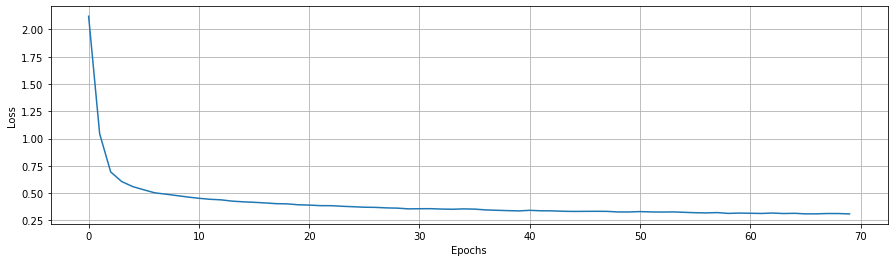

In [ ]:
# Present results

# Print accuracy if test data and test labels are provided
if (X_test is not None) and (y_test is not None):
    test_predictions = nn.predict(X_test)
    print("Accuracy on test set: %.4f" %accuracy_score(test_predictions, y_test))

# If eval mode was NOT used, plot only the loss
if not eval_mode:
    pl.figure(figsize=(15,4))
    pl.plot(results)
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.grid()

# If eval mode was used, plot training set and test set accuracy
else:
    pl.figure(figsize=(15,4))
    pl.plot(results[:,1], label='Training set')
    pl.plot(results[:,2], label='Test test')
    pl.xlabel('Epochs')
    pl.ylabel('Accuracy')
    pl.legend()
    pl.grid()

The code below was used to produce the labels for the test data.

In [ ]:
test_data_id = '1ggYsoPpMztw2FM8wFEgk8HqXFumjDZ79'

# Download training data
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':test_data_id}) 
downloaded.GetContentFile('test_128.h5', 'r')
with h5py.File('test_128.h5') as H:
    data = np.copy(H['data'])

X_test = data
test_predictions = nn.predict(X_test)
test_labels = np.argmax(test_predictions, axis=1)

from google.colab import drive
drive.mount('/content/drive')

hf = h5py.File('/content/drive/My Drive/Predicted_labels.h5', 'w')
hf.create_dataset('label', data=test_labels)
hf.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
